# Deploy and monitor a machine learning workflow for Image Classification

- ## Data Staging
- ## Model Training
- ## Getting ready to deploy
- ## Draft Lambdas and Step Function Workflow
- ## Testing and Evaluation


## Data Staging

We'll use a sample dataset called CIFAR to simulate the challenges Scones Unlimited are facing in Image Classification. In order to start working with CIFAR we'll need to:

1. Extract the data from a hosting service
2. Transform it into a usable shape and format
4. Explore the data
5. Filter the dataset_train and dataset_meta objects to find the label numbers for Bicycle and Motorcycles
6. Convert the object into the dataframe 
7. Save the data to the local machine
7. Load it into a production system



In [3]:
download_url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
file_name = "cifar.tar.gz"

### 1. Extract the data from the hosting service

- In the cell below, define a function `extract_cifar_data` that extracts python version of the CIFAR-100 dataset. 
- The CIFAR dataaset is open source and generously hosted by the University of Toronto at: https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz 
- This will download a zip file

In [4]:
import requests
import os

def extract_cifar_data(url, file_name):
    """
    Downloads the CIFAR-100 dataset from the specified URL and saves it as a gzipped file.

    Parameters:
    url (str): The URL from which the CIFAR-100 dataset will be downloaded.
    filename (str, optional): The name of the file where the downloaded dataset will be saved.
                              Defaults to "cifar.tar.gz".

    Returns:
    None
    """
    if not os.path.exists(file_name):
        # Send a GET request to the specified URL to get the dataset content
        r = requests.get(url)

        # Open the file in binary write mode and write the dataset content into it
        with open(file_name, "wb") as file_context:
            file_context.write(r.content)

        # Function execution completes, no return value necessary
        return

In [5]:
extract_cifar_data(download_url, file_name)

### 2. Transform the data into a usable shape and format

- Clearly, distributing the data as a gzipped archive makes sense for the hosting service! It saves on bandwidth, storage, and it's a widely-used archive format. 
- A new folder `cifar-100-python` should be created, containing `meta`, `test`, and `train` files, these are serialized python object. These files are `pickles` and the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html) provides a simple script that can be used to load them. 
- The zip file has 3 compressed form of python serialized object (serialized dict using pickle).
- So we will extract the zip and then unpickle them into python dict.

In [8]:
import tarfile

def unzip_data(file_name, mode="r:gz"):
    
    if not os.path.exists("cifar-100-python"):
        # Open the gzipped tar file in read mode
        with tarfile.open(file_name, mode) as tar:
            # Extract all the contents of the tar file
            tar.extractall()

In [3]:
import pickle

def de_serialize_pickle_data():
    # Open and load the metadata file
    with open("./cifar-100-python/meta", "rb") as f:
        # Load metadata using pickle, specifying 'bytes' encoding
        dataset_meta = pickle.load(f, encoding='bytes')

    # Open and load the test data file
    with open("./cifar-100-python/test", "rb") as f:
        # Load test data using pickle, specifying 'bytes' encoding
        dataset_test = pickle.load(f, encoding='bytes')

    # Open and load the training data file
    with open("./cifar-100-python/train", "rb") as f:
        # Load training data using pickle, specifying 'bytes' encoding
        dataset_train = pickle.load(f, encoding='bytes')
    
    return dataset_meta, dataset_test, dataset_train

In [95]:
unzip_data(file_name)

In [5]:
dataset_meta, dataset_test, dataset_train = de_serialize_pickle_data()

### 3. Explore the data

In [6]:
!pip install matplotlib


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [96]:
print(type(dataset_train),type(dataset_train[b'filenames']), type(dataset_train[b'fine_labels']))

<class 'dict'> <class 'list'> <class 'list'>


In [7]:
type(dataset_meta), type(dataset_test), type(dataset_train)

(dict, dict, dict)

In [8]:
dataset_train.keys(), dataset_test.keys(), dataset_meta.keys()

(dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data']),
 dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data']),
 dict_keys([b'fine_label_names', b'coarse_label_names']))

In [9]:
dataset_train[b'data'], len(dataset_train[b'data']), len(dataset_train[b'data'][0])

(array([[255, 255, 255, ...,  10,  59,  79],
        [255, 253, 253, ..., 253, 253, 255],
        [250, 248, 247, ..., 194, 207, 228],
        ...,
        [248, 240, 236, ..., 180, 174, 205],
        [156, 151, 151, ..., 114, 107, 126],
        [ 31,  30,  31, ...,  72,  69,  67]], dtype=uint8),
 50000,
 3072)

Let's transform one of our images. 
Using python, we can stack these channels into a 32x32x3 array, and save it as a PNG file:

In [10]:
import numpy as np
import matplotlib.pyplot as plt


def plot_single_image(image_array):
    channel_size = 32*32
    # Load the dataset_train and select the first row
    row = image_array

    # Split the row into red, green, and blue channels
    red, green, blue = row[0:channel_size], row[channel_size:channel_size*2], row[channel_size*2:channel_size*3]
    
    # Reshape the channel data into 32x32 arrays
    red = red.reshape(32, 32)
    green = green.reshape(32, 32)
    blue = blue.reshape(32, 32)
    print(red.shape, red[0].shape)

    # Combine the individual channels into a 32x32x3 image using NumPy's dstack function
    combined = np.dstack((red, green, blue))
    
    plt.imshow(combined)

(32, 32) (32,)


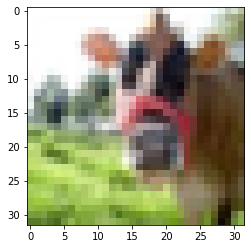

In [11]:
plot_single_image(dataset_train[b'data'][0])

Looks like a cow! Let's check the label. `dataset_meta` contains label names in order, and `dataset_train` has a list of labels for each row.

Index in `dataset_meta[b'fine_label_names']` are actually the labels.

In [12]:
dataset_train[b'fine_labels'][0:5], dataset_meta[b'fine_label_names'][0:5]

([19, 29, 0, 11, 1], [b'apple', b'aquarium_fish', b'baby', b'bear', b'beaver'])

In [13]:
dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][0]]

b'cattle'

In [14]:
print(dataset_train[b'filenames'][0])

b'bos_taurus_s_000507.png'


"Taurus" is the name of a subspecies of cattle.

- All unpicked objects are Python dictionaries.
- The train dictionary has 5 keys:
    1. `b'filenames'`
    2. `b'batch_label'`
    3. `b'fine_labels'`
    4. `b'coarse_labels'`
    5. `b'data'`





- The test dictionary has 5 keys:
    1. `b'filenames'`
    2. `b'batch_label'`
    3. `b'fine_labels'`
    4. `b'coarse_labels'`
    5. `b'data'`
    
 
 
 - The meta dictionary has 2 keys:
    1. `b'fine_label_names'`
    2. `b'coarse_label_names'`
    3. `b'fine_labels'`
    4. `b'coarse_labels'`
    5. `b'data'`
    
    
    
- As documented on the homepage, `b'data'` 50000 contains rows of 3073 unsigned integers, representing three channels (red, green, and blue) for one 32x32 pixel image per row. So total = 32x32x3 = 3072 per index.


- `dataset_train[b'fine_labels']` contains the label for the image, this label act as index in `dataset_meta[b'fine_label_names']`


### 4. Filter the dataset_train and dataset_meta objects for Bicycle and Motorcycles

In [15]:
!pip3 install pandas


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
for  index, label_name in enumerate(dataset_meta[b'fine_label_names']):
    if label_name in [b'bicycle',b'motorcycle']:
        print( f"Label Name: {label_name},  Label Number: {index}")

Label Name: b'bicycle',  Label Number: 8
Label Name: b'motorcycle',  Label Number: 48


### 5. Convert the object into the dataframe

In [46]:
print(range(len(dataset_train[b'filenames'])))

range(0, 50000)


In [92]:
import pandas as pd

# Construct the dataframe for training data
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames'])) # for adding the index column
})

# Drop all rows from df_train where label is not 8 or 48
df_train = df_train.loc[df_train["labels"].isin([8,48])]

# Decode df_train.filenames so they are regular strings
#  b'bike_s_000682.png' ==> bike_s_000682.png
df_train["filenames"] = df_train["filenames"].apply(lambda x: x.decode("utf-8"))

# Construct the dataframe for testing data
df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

# Drop all rows from df_test where label is not 8 or 48
df_test = df_test.loc[df_test["labels"].isin([8,48])]

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(lambda x: x.decode("utf-8"))

In [94]:
df_train.head()

In [76]:
df_train.describe()

In [77]:
df_test.head()

In [78]:
df_test.describe()

- `df_train` and `df_test` have filename, lable, and index from original data dict

### 6. Save the data to the local machine

In [ ]:
!mkdir ./train
!mkdir ./test

In the previous sections we introduced you to several key snippets of code:

1. Grabbing the image data:

```python
dataset_train[b'data'][0]
```

2. A simple idiom for stacking the image data into the right shape

```python
import numpy as np
np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))
```

3. A simple `matplotlib` utility for saving images

```python
plt.imsave(path+row['filenames'], target)
```

In [60]:
def save_images(image_data_row_num , image_filename, target_folder_path, images_dataset):
    """A function for saving images from the dataset to the provided target path folders 
    
    Arguments:
    image_data_row_num  -- image data row that needs to be saved into a folder
    image_filename            -- filename with which the image needs to be saved
    target_folder_path        --  target folder path where image needs to be saved
    images_dataset             -- original images dataset containing the data for the given images
    
    """
    #Grab the image data in row-major form
    img_data =  images_dataset[b'data'][image_data_row_num]
    
    # Consolidated stacking/reshaping from earlier
    target = np.dstack((
        img_data[0:1024].reshape(32,32),
        img_data[1024:2048].reshape(32,32),
        img_data[2048:].reshape(32,32)
    ))
    
    # Save the image
    try:
        image_file_path = os.path.join(target_folder_path, image_filename)
        plt.imsave(image_file_path, target)
    except e:
        return f"Error Saving {image_filename} to folder {target_folder_path} \n Error: {e}  "
    # Return any signal data you want for debugging
    return f"Successfully saved {image_filename} to folder {target_folder_path}."

In [85]:
#Saving all the Train dataset images
for df_row in df_train.itertuples():
    print(save_images(df_row.row, df_row.filenames,"./train", dataset_train))

#Saving all the Test dataset images
for df_row in df_test.itertuples():
    print(save_images(df_row.row, df_row.filenames,"./test", dataset_test))

(16, b'bike_s_000682.png')
(30, b'bike_s_000127.png')
(130, b'cycle_s_002598.png')
(152, b'minibike_s_000824.png')
(195, b'motorcycle_s_001856.png')
(219, b'bicycle_s_000537.png')
(251, b'moped_s_000169.png')
(252, b'motorcycle_s_001453.png')
(298, b'safety_bike_s_000482.png')
(370, b'dirt_bike_s_000124.png')
(390, b'minibike_s_001863.png')
(392, b'minibike_s_001177.png')
(408, b'motorcycle_s_001792.png')
(560, b'minibike_s_001969.png')
(575, b'velocipede_s_001585.png')
(576, b'moped_s_000035.png')
(663, b'bike_s_000256.png')
(682, b'minibike_s_000571.png')
(785, b'motorcycle_s_001119.png')
(839, b'moped_s_000009.png')
(921, b'ordinary_bicycle_s_000023.png')
(922, b'motorcycle_s_001693.png')
(964, b'safety_bicycle_s_001570.png')
(984, b'safety_bike_s_000989.png')
(996, b'bicycle_s_001673.png')
(1023, b'ordinary_bicycle_s_000100.png')
(1114, b'bike_s_000544.png')
(1132, b'motorcycle_s_001368.png')
(1158, b'bicycle_s_000392.png')
(1170, b'motorbike_s_000221.png')
(1255, b'safety_bike_s_0

### 7. Load the data

Now we can load the data into S3.

Using the sagemaker SDK grab the current region, execution role, and bucket.

In [ ]:
import sagemaker


bucket= "sidd0final0project0bucket"
print("Default Bucket: {}".format(bucket))

region = "us-east-1"
print("AWS Region: {}".format(region))

role ="arn:aws:iam::271232843618:role/service-role/AmazonSageMaker-ExecutionRole-20231021T211247"
print("RoleArn: {}".format(role))

With this data we can easily sync your data up into S3!

In [ ]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/

## Model Training

1. Create metadata for image classification on SageMaker
    1. `train.lst`
    2. `test.lst`



2. Upload metadata to S3 using `boto3`
3. Get algorithm using ECR image
4. Create estimator
    - `image_uri` will be the ECR image URI
5. Add hyperparameters to the estimator

6. Add model inputs
    1. `Train data`
    2. `Test data`
    3. `Train metadata (train.lst)`
    4. `Test metadata (test.lst)`


7. Fit the model


For Image Classification, Sagemaker [also expects metadata](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) e.g. in the form of TSV files with labels and filepaths.

### 1. Creating metadata for image classification on SageMaker

In [ ]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

### 2. Uploading metadata to S3 using boto3


In [ ]:
import boto3 # for interacting with AWS services

# Upload files
boto3.Session().resource('s3').Bucket(
    bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('test.lst').upload_file('./test.lst')

### 3. Getting algorithm using ECR image

- Using the `bucket` and `region` info we can get the latest prebuilt container to run our training job, and define an output location on our s3 bucket for the model. 
- Use the `image_uris` function from the SageMaker SDK to retrieve the latest `image-classification` image below
- The retrieve method is used to get the ECR (Elastic Container Registry) URI for a pre-built SageMaker Docker image.

In [ ]:
algo_image = sagemaker.image_uris.retrieve("image-classification", region=region, version="latest")

### 4. Creating estimator

In [ ]:
s3_output_location = f"s3://{bucket}/models/image_model"

In [ ]:
# Create the Estimator
img_classifier_model=sagemaker.estimator.Estimator(
    image_uri = algo_image,
    role= role,
    instance_count = 1,
    instance_type = 'ml.p3.2xlarge',
    output_path = s3_output_location,
    sagemaker_session = sagemaker.Session()
)

### 5. Adding hyperparameters to the estimator

In [ ]:
img_classifier_model.set_hyperparameters(
    image_shape='3,32,32',
    num_classes=2,
    num_training_samples= df_train.shape[0]
)

### 6. Adding model inputs

In [ ]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test.lst",
            content_type="application/x-image"
        )
}

### 7. Fitting the model

In [ ]:
img_classifier_model.fit(inputs=model_inputs)

- If all goes well, you'll end up with a model topping out above `.8` validation accuracy. With only 1000 training samples in the CIFAR dataset, that's pretty good.
- We could definitely pursue data augmentation & gathering more samples to help us improve further, but for now let's proceed to deploy our model.


## Getting ready to deploy

### 1. Creating data capture

In [ ]:
from sagemaker.model_monitor import DataCaptureConfig #  to configure data capture for endpoints.

# Define the destination S3 URI for data capture
data_capture_config = DataCaptureConfig(
    enable_capture=True, # input/output payloads will be captured.
    sampling_percentage=100, # 100 means capturing data from every request.
    destination_s3_uri=f"s3://{bucket}/data_capture" #  will be saved in this S3 bucket
)


### 2. Model deployment and creating the endpoint

In [ ]:
deployment = img_classifier_model.deploy(
    instance_type="ml.m5.xlarge",  
    initial_instance_count=1,
    data_capture_config=data_capture_config,
)

In [ ]:
endpoint = deployment.endpoint_name
print(endpoint)

### 3. Instantiating a predictor

In [ ]:
predictor = sagemaker.predictor.Predictor(
    endpoint_name=endpoint, 
    sagemaker_session=sagemaker.Session()
)

### 4. Making Prediction

In [ ]:
from sagemaker.serializers import IdentitySerializer
import base64

predictor.serializer = IdentitySerializer("image/png")
with open("./test/bicycle_s_001789.png", "rb") as f:
    payload = f.read()

    
inference = predictor.predict(payload, initial_args={'ContentType': 'application/x-image'})

In [ ]:
print(inference)

- `inference` object is an array of two values, the predicted probability value for each of your classes (bicycle and motorcycle respectively.) 
- So, for example, a value of `b'[0.91, 0.09]'` indicates the probability of being a bike is 91% and being a motorcycle is 9%.

## Draft Lambdas and Step Function Workflow
    1. Lambad 1: Serialize target data from S3
    2. Lambad 2: Classification of image
    3. Lambda 3: Check for confidence threshold

### Lambad 1: Serialize target data from S3

- Download an image file from an S3 bucket
- Convert the image data into a base64-encoded format
- Return this data along with some metadata as a response

__event input__
```
{
    "s3_key": "test/bicycle_s_000030.png",
    "s3_bucket": "ml-flow-sidd"
}
```

- The lambda_handler function is defined, which is the entry point for the Lambda function. 
- This function takes two parameters: event and context. 
- The event parameter contains information about the event that triggered the Lambda function


In [2]:
import boto3
import base64 #  for encoding and decoding data in base64 forma

s3 = boto3.client('s3')

def lambda_handler(event, context):
    """A function to serialize target data from S3"""
    
    key = event["s3_key"]
    bucket = event["s3_bucket"]
    
    # Download the data from s3 to /tmp/image.png
    boto3.resource('s3').Bucket(bucket).download_file(key, "/tmp/image.png")
    
    with open("/tmp/image.png", "rb") as f:
        image_data = base64.b64encode(f.read())

    return {
        'statusCode': 200,
        'body': {
            "image_data": image_data,
            "s3_bucket": bucket,
            "s3_key": key,
            "inferences": []
        }
    }

### Lambad 2: Classification of image

- Creates a SageMaker runtime client using boto3.client('runtime.sagemaker') to interact with the SageMaker endpoint.
- Send an image (in base64-encoded format) to an Amazon SageMaker endpoint for inference 
- Return the inference results

In [ ]:
import boto3
import json
import base64

ENDPOINT_NAME = endpoint

# We will be using the AWS's lightweight runtime solution to invoke an endpoint.
runtime = boto3.client('runtime.sagemaker')

def lambda_handler(event, context):
    
    image = base64.b64decode(event['body']['image_data'])
    
    response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                       ContentType='image/png',
                                       Body=image)
    
    event["inferences"] = json.loads(response['Body'].read().decode('utf-8'))
    return {
        'statusCode': 200,
        'body': event
    }


### Lambda 3: Check for confidence threshold

In [ ]:
import json

# Define the threshold for confidence
THRESHOLD = 0.8 

def lambda_handler(event, context):
    
    inferences =  event['body']['inferences']
    
    # Check if any values in our inferences are above THRESHOLD
    meets_threshold = any(confidence >= THRESHOLD for confidence in inferences)
    

    # If our threshold is met, pass our data back out of the Step Function,
    # else, end the Step Function with an error
    if meets_threshold:
        pass
    else:
        raise Exception("THRESHOLD_CONFIDENCE_NOT_MET")
    
    return {
        'statusCode': 200,
        'body': json.dumps(event)
    }



## Testing and Evaluation

### 1. Generating multiple test cases (event input for lambda 1)

In [ ]:
import random
import boto3
import json


def generate_test_case():
    # Setup s3 in boto3
    s3 = boto3.resource('s3')
    
    # Randomly pick from sfn or test folders in our bucket
    objects = s3.Bucket(bucket).objects.filter(Prefix="test/")
    
    # Grab any random object key from that folder!
    obj = random.choice([x.key for x in objects])
    
    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket,
        "s3_key": obj
    })
generate_test_case()

### 2. Pulling in the JSONLines data from your inferences

    1. Downloading the capture (in JSONL format)
    2. Extracting JSONL format in dict
    3. Loading inferences along with timestamp
    4. Visulaizing (the input images, the resulting inferences, and the timestamps.)
    
 - The data are in JSONLines format, where multiple valid JSON objects are stacked on top of eachother in a single `jsonl` file.

In [ ]:
from sagemaker.s3 import S3Downloader #  utilities for downloading data from Amazon S3.

# In S3 your data will be saved to a datetime-aware path
data_path = "s3://sidd0final0project0bucket/data_capture/image-classification-2023-10-25-10-26-31-173/AllTraffic/2023/10/26/14/"

S3Downloader.download(data_path, "captured_data")

In [ ]:
!pip install jsonlines

import jsonlines
import os

# List the file names we downloaded
file_handles = os.listdir("./captured_data")

# Dump all the data into an array
json_data = []
for jsonl in file_handles:
    with jsonlines.open(f"./captured_data/{jsonl}") as f:
        json_data.append(f.read())

In [ ]:
# Define how we'll get our data
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp

In [ ]:
import matplotlib.pyplot as plt

# Populate the data for the x and y axis
x = []
y = []
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    
    y.append(max(inference))
    x.append(timestamp)

# Plot the data
plt.scatter(x, y, c=['r' if k<. else 'b' for k in y ])
plt.axhline(y=0.8, color='g', linestyle='--')
plt.ylim(bottom=.6)

# Add labels
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Pictured with confidence threshold for production use", size=10)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()

plt.show()

### Todo: build your own visualization


In [ ]:
plt.figure(figsize=(15,5))
plt.plot(x, y)    
plt.xlabel("Inference")
plt.ylabel("Confidence Level")
plt.gcf().autofmt_xdate()
plt.show()